In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import glob
import seaborn as sns
import itertools
import scipy
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def make_fc_frame(subid, pipeline_dir, atlas_dir):
    fc = {}
    for file in glob.glob(f'../../data/extracted/{subid}/roi_timeseries/_scan*/{pipeline_dir}/{atlas_dir}/*.csv'):
        run_name = file.split('/')[6]

        # make correlation matrix from roi timeseries file
        run_cor_mat = np.corrcoef(np.loadtxt(file, delimiter = ',').T)

        # upper triangle without diagonal
        upper_triangle = run_cor_mat[np.triu_indices_from(run_cor_mat, k=1)]
        fc[run_name] = upper_triangle 
    out = pd.DataFrame(fc)
    return(out)

In [3]:
def calc_split_half_similarity(d):
    df_list = []
    first_half = d[['_scan_movie_run-1', '_scan_movie_run-2', '_scan_movie_run-3', '_scan_movie_run-4']]
    second_half = d[['_scan_movie_run-5', '_scan_movie_run-6', '_scan_movie_run-7', '_scan_movie_run-8']]
    
    templates = [first_half.mean(axis = 1), second_half.mean(axis = 1)]
    for template_ind in [0,1]:
        for scans in [1,2,3,4]:
            combs = itertools.combinations([1,2,3,4], scans)
            cor_vals = []
            for i in list(combs):
                inds = np.array(i) - 1
                if template_ind == 0:
                    df_slice = second_half.iloc[:, inds]
                else:
                    df_slice = first_half.iloc[:, inds]
                df_slice_mean = df_slice.mean(axis = 1)
                cor_vals.append(np.corrcoef(df_slice_mean, templates[template_ind])[0,1])
            temp = pd.DataFrame({'similarity': cor_vals})
            temp['scans'] = scans
            temp['template'] = template_ind
            df_list.append(temp)
                
    # merge dataframes            
    similarity_merged = pd.concat(df_list)
    return(similarity_merged)

In [4]:
check_1 = make_fc_frame(subid = '01_movie',
             pipeline_dir = '_selector_CSF-2mmE-M_aC-CSF+WM-2mm-DPC5_G-M_M-SDB_P-2_BP-B0.01-T0.1',
             atlas_dir = '_mask_CorticalAreaParcellationfromRestingStateCorrelationsGordon2014_mask_file_..ndmg_atlases..label..Human..CorticalAreaParcellationfromRestingStateCorrelationsGordon2014.nii.gz')

In [5]:
all_subs = []
fc_lists = []
for subid in ['01_movie', '02_movie', '04_movie', '05_movie', '06_movie']:
    print(subid)
    multi_list = []
    fc_list = []
    for atlas_path in glob.glob('../../data/extracted/01_movie/roi_timeseries/_scan_movie_run-1/_selector_CSF-2mmE-M_aC-CSF+WM-2mm-DPC5_G-M_M-SDB_P-2_BP-B0.01-T0.1/_mask*'):
        for pipeline_path in glob.glob('../../data/extracted/01_movie/roi_timeseries/_scan_movie_run-1/*'):
            pipeline = (pipeline_path.split('/')[7])
            atlas = atlas_path.split('/')[8]
            fc_df = make_fc_frame(subid = subid, pipeline_dir = pipeline, atlas_dir = atlas)
            sim_df = calc_split_half_similarity(fc_df)
            sim_df['pipeline'] = pipeline
            sim_df['atlas'] = atlas
            fc_df['pipeline'] = pipeline
            fc_df ['atlas'] = atlas
            fc_list.append(fc_df)
            multi_list.append(sim_df)
    
    # participant-level dataframes
    multi_merge = pd.concat(multi_list)
    multi_merge['subid'] = subid
    
    fc_lists.append(fc_list)
    all_subs.append(multi_merge)

01_movie
02_movie
04_movie
05_movie
06_movie


In [6]:
subs_merge = pd.concat(all_subs)

In [7]:
subs_merge.head()

,similarity,scans,template,pipeline,atlas,subid
0,0.849706,1,0,_selector_CSF-2mmE-M_aC-CSF+WM-2mm-DPC5_G-M_M-...,_mask_Schaefer2018-200-node_space-MNI152NLin6_...,01_movie
1,0.884292,1,0,_selector_CSF-2mmE-M_aC-CSF+WM-2mm-DPC5_G-M_M-...,_mask_Schaefer2018-200-node_space-MNI152NLin6_...,01_movie
2,0.876130,1,0,_selector_CSF-2mmE-M_aC-CSF+WM-2mm-DPC5_G-M_M-...,_mask_Schaefer2018-200-node_space-MNI152NLin6_...,01_movie
3,0.845041,1,0,_selector_CSF-2mmE-M_aC-CSF+WM-2mm-DPC5_G-M_M-...,_mask_Schaefer2018-200-node_space-MNI152NLin6_...,01_movie
0,0.906238,2,0,_selector_CSF-2mmE-M_aC-CSF+WM-2mm-DPC5_G-M_M-...,_mask_Schaefer2018-200-node_space-MNI152NLin6_...,01_movie


In [8]:
subs_merge['GSR'] = subs_merge.pipeline.str.contains('G-M')
subs_merge.replace({'_mask_CorticalAreaParcellationfromRestingStateCorrelationsGordon2014_mask_file_..ndmg_atlases..label..Human..CorticalAreaParcellationfromRestingStateCorrelationsGordon2014.nii.gz': 'Gordon2014',
                     '_mask_Schaefer2018-200-node_space-MNI152NLin6_res-1x1x1_mask_file_..ndmg_atlases..label..Human..Schaefer2018-200-node_space-MNI152NLin6_res-1x1x1.nii.gz': 'Schafer-200',
                     '_mask_Schaefer2018-300-node_space-MNI152NLin6_res-1x1x1_mask_file_..ndmg_atlases..label..Human..Schaefer2018-300-node_space-MNI152NLin6_res-1x1x1.nii.gz': 'Schafer-300',
                     '_mask_Schaefer2018-400-node_space-MNI152NLin6_res-1x1x1_mask_file_..ndmg_atlases..label..Human..Schaefer2018-400-node_space-MNI152NLin6_res-1x1x1.nii.gz': 'Schafer-400',
                     '_mask_Schaefer2018-1000-node_space-MNI152NLin6_res-1x1x1_mask_file_..ndmg_atlases..label..Human..Schaefer2018-1000-node_space-MNI152NLin6_res-1x1x1.nii.gz': 'Schafer-1000'}, inplace = True)

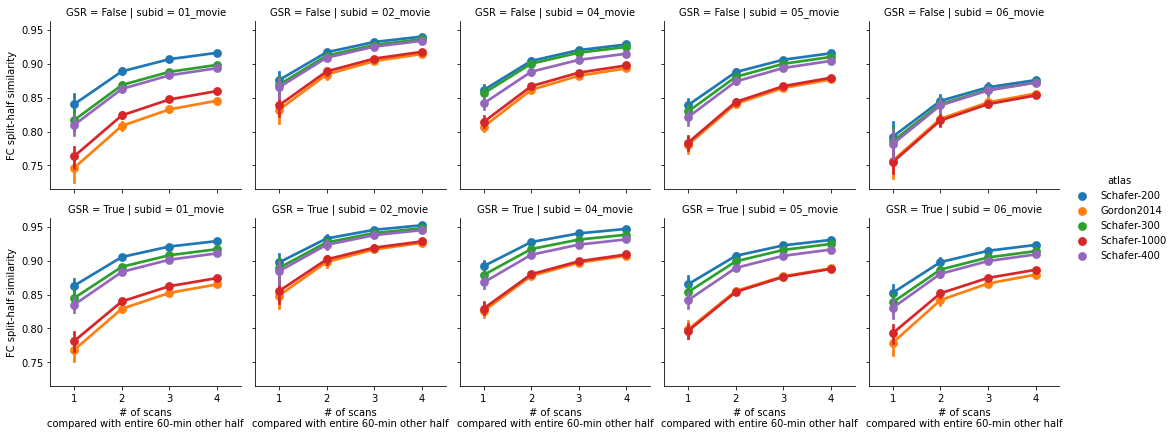

In [11]:
g =sns.catplot(x="scans", y="similarity",
                hue="atlas", col = 'subid', row = 'GSR', kind = 'point',
                data=subs_merge, height = 3)

g.set_axis_labels('# of scans\ncompared with entire 60-min other half', "FC split-half similarity")

g.savefig('../../plots/init_preproc_similarity_5_subs.pdf')

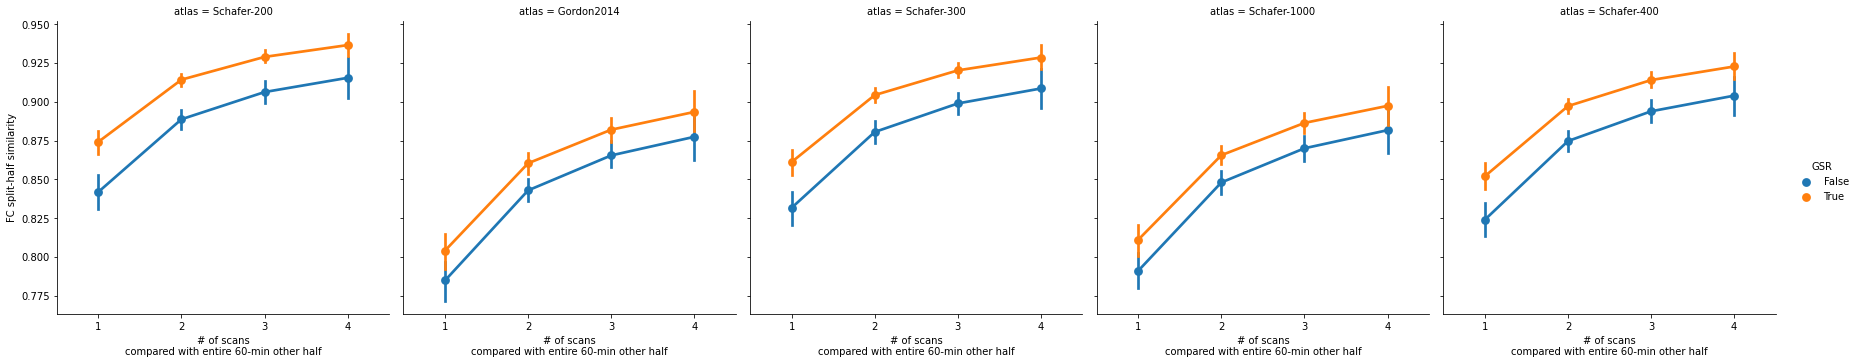

In [14]:
g =sns.catplot(x="scans", y="similarity",
                hue="GSR", col = 'atlas',kind = 'point',
                data=subs_merge, height = 5)

g.set_axis_labels('# of scans\ncompared with entire 60-min other half', "FC split-half similarity")

g.savefig('../../plots/init_preproc_gsr_similarity_5_subs.pdf')

In [ ]:
# def prep_discrim(fc_lists):
#     for fc_list in fc_lists:
#             for fc_obj in fc_list:
#                 df_list = []
#                 first_half = fc_obj[['_scan_movie_run-1', '_scan_movie_run-2', '_scan_movie_run-3', '_scan_movie_run-4']]
#                 second_half = fc_obj[['_scan_movie_run-5', '_scan_movie_run-6', '_scan_movie_run-7', '_scan_movie_run-8']]
                            
                  
#                 for runs in [1,2,3,4]:
#                     mean_1 = first_half.iloc[:, 0:runs].mean(axis = 1)
#                     mean_2 = first_half.iloc[:, 0:runs].mean(axis = 1)

In [ ]:
# fc_lists = [fc_list]
# prep_discrim(fc_lists)

In [ ]:
# fc_lists

In [16]:
fc_frames = []
for subid in ['01_movie', '02_movie', '04_movie', '05_movie', '06_movie']:
    fc_frame = make_fc_frame(subid = subid,  pipeline_dir = '_selector_CSF-2mmE-M_aC-CSF+WM-2mm-DPC5_G-M_M-SDB_P-2_BP-B0.01-T0.1',
             atlas_dir = '_mask_CorticalAreaParcellationfromRestingStateCorrelationsGordon2014_mask_file_..ndmg_atlases..label..Human..CorticalAreaParcellationfromRestingStateCorrelationsGordon2014.nii.gz')
    fc_frame['subid'] = subid
    fc_frames.append(fc_frame)

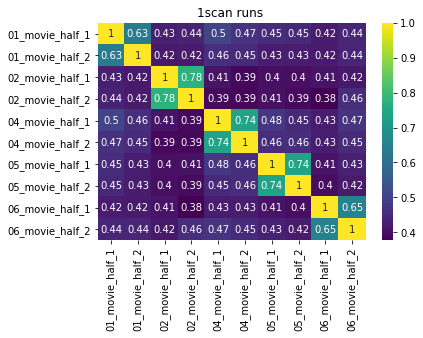

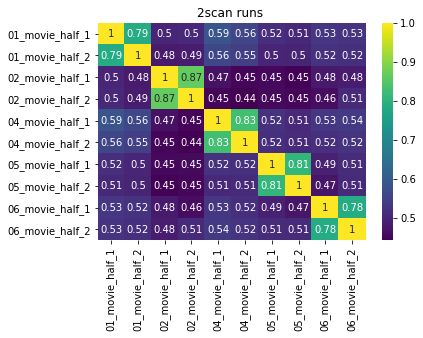

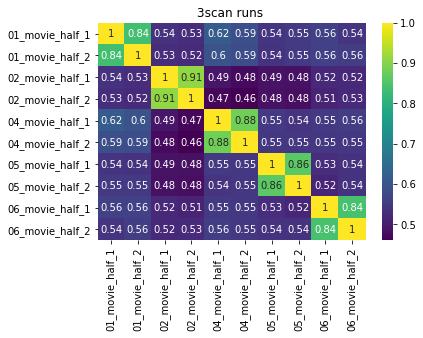

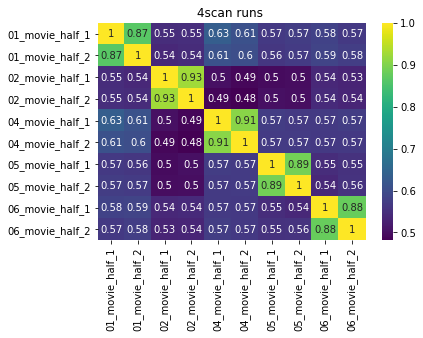

In [17]:
for runs in [1,2,3,4]:
    h = {}
    for frame in fc_frames:    
        first_half = frame[['_scan_movie_run-1', '_scan_movie_run-2', '_scan_movie_run-3', '_scan_movie_run-4']]
        second_half = frame[['_scan_movie_run-5', '_scan_movie_run-6', '_scan_movie_run-7', '_scan_movie_run-8']]         
        h[frame.subid[0] + '_half_1'] = first_half.iloc[:, 0:runs].mean(axis = 1)
        h[frame.subid[0] + '_half_2']= second_half.iloc[:, 0:runs].mean(axis = 1)
    
    ax = plt.axes()
    sns.heatmap(pd.DataFrame(h).corr(),cmap = 'viridis', annot = True, ax = ax)
    ax.set_title(str(runs) +  'scan runs ')
    plt.show()

In [18]:
h = {}
for frame in fc_frames:
    for i in [1,7]:        
        h[frame.subid[0] + '_piece_' + str(i)] = scipy.stats.zscore(frame.iloc[:, i])

In [19]:
h

{'01_movie_piece_1': array([-1.40162495, -0.14205064,  0.94596561, ...,  3.55622507,
         3.37534929,  3.97657118]),
 '01_movie_piece_7': array([-1.562263  , -1.45892144,  0.20574021, ...,  3.78597175,
         3.48667843,  3.96390862]),
 '02_movie_piece_1': array([-0.69744929, -0.38960014,  1.72546011, ...,  3.91903182,
         3.8428087 ,  4.30467457]),
 '02_movie_piece_7': array([-1.36109377, -0.21646553,  0.9408126 , ...,  3.66663034,
         3.57325663,  3.90749191]),
 '04_movie_piece_1': array([-1.6187455 , -0.11061991,  0.90940645, ...,  4.28014605,
         3.81443232,  4.96715395]),
 '04_movie_piece_7': array([-0.44526427, -0.37666184,  0.50976606, ...,  3.7206292 ,
         3.46018429,  4.66484438]),
 '05_movie_piece_1': array([-1.04230232, -0.22332704,  1.31849462, ...,  3.67032136,
         2.71086048,  3.27403467]),
 '05_movie_piece_7': array([-1.79903937, -1.00129426,  1.12387329, ...,  4.22826847,
         3.85807768,  3.31084944]),
 '06_movie_piece_1': array([-1.4

In [20]:
t = pd.DataFrame(h).transpose()

In [21]:
x = t.to_numpy()

In [22]:
y = np.array(t.index.str[0:2]).astype(int)

In [23]:
from hyppo.discrim import DiscrimOneSample

In [24]:
stat, pvalue = DiscrimOneSample().test(x, y)

ValueError: Number of samples is too low

In [25]:
stat, pvalue

NameError: name 'stat' is not defined